## Load Libraries / Import Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')
spray = pd.read_csv('../datasets/spray.csv')
weather = pd.read_csv('../datasets/weather.csv')

## Train Dataset - Data Cleaning/EDA

In [3]:
train.shape

(10506, 12)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [5]:
#Convert date to datetime

train['Date'] = pd.to_datetime(train['Date'])

### Null Values / Duplicates

There are no null values in the train dataset

In [6]:
train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

- There are 1062 duplicates in the train dataset. 
- As per the data description in Kaggle, each entry can only contain max 50 mosquitoes, and any additional mosquitoes found in the trap will be added in a new row. This would lead to multiple NumMosquitos = 50 entries, which are not actually duplicates.
- However, there are some duplicate entries with only 1 mosquito - this is likely to be incorrect and we will remove the duplicate since they cannot be explained (46 entries - very small relative to the entire dataset)

In [7]:
train.duplicated(keep=False).sum()

1062

In [8]:
train.loc[train.duplicated(keep=False),:].head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
98,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
293,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
350,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0


Removing dupes with 1 in 'NumMosquitos'

In [9]:
#these are probably duped entries (1 mosquito)

train.loc[(train.duplicated(keep=False)) & (train['NumMosquitos'] == 1),:].head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
98,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
511,2007-07-18,"3300 West Randolph Street, Chicago, IL 60612, USA",CULEX RESTUANS,33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",41.883284,-87.705085,8,1,0
512,2007-07-18,"3300 West Randolph Street, Chicago, IL 60612, USA",CULEX RESTUANS,33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",41.883284,-87.705085,8,1,0
818,2007-08-01,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0


In [10]:
train = train.loc[~((train.duplicated()) & (train['NumMosquitos'] == 1)),:]

In [11]:
train.shape

(10460, 12)

For the remaining 'duplicates', we are going to combine them into a single entry. For example, if a trap has 120 mosquitoes in a single date - they would appear as 3 rows in the current dataset (50,50,20), but we are now going to combined them into 1 row of 120 mosquitoes. 

In [12]:
#remaning dupes = when trap has >50, new row added 
#(from data dict: These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50.)

train.loc[train.duplicated(keep=False),:].head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
293,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
350,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
351,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
353,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0


In [13]:
#Group similar entries into a single row.

train = train.groupby([col for col in train.columns if col not in ['NumMosquitos', 'WnvPresent']]).sum().sort_values(by='WnvPresent')
train.reset_index(inplace=True)

In [14]:
#Return those summed 'WnvPresent' values to 1 

train['WnvPresent'] = train['WnvPresent'].map(lambda x : 1 if x > 0 else x)

In [15]:
train['WnvPresent'].value_counts()

0    8018
1     457
Name: WnvPresent, dtype: int64

In [16]:
train.shape

(8475, 12)

## Weather - Background Research / Dataset

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. Provided is the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 

**Location of Weather Stations**  
Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level

Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

![alt text](Chicago-Weather.png "Title")


### How does weather affect the West Nile Virus?

Weather factors are important drivers of WNV transmission due to their direct effect in mosquito biology.

* According to [study drivers of West Nile virus human illness in the Chicago](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227160)
    * higher than normal average annual temperatures are associated with an increased likelihood of higher WNV disease incidence
    * higher than normal precipitation was positively associated with higher human WNV cases in the eastern region of the United States, but this relationship was reversed for the western region
    * Another study identified drought as an important driver of WNV epidemics in the United States
    * hot weather conditions, warm winters, and higher MIR in earlier weeks increased the probability of an area of having a WNV human case.

### Weather Data Dictionary
Features were categorized according to the variable they're measuring

|Feature|Category|Type|Description|  
|:--|:-:|:-:|:--|  
|Station|Station|int64|Station Type|  
|Date|Date|object|Date of data collection|  
|Tmax|Temperature|int64|Maximum Temperature|  
|Tmin|Temperature|int64|Minimum Temperature|
|Tavg|Temperature|object|Average Temperature|
|Depart|Temperature|int64|Departure from Normal Temperature|
|Dewpoint|Temperature|int64|The temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%|
|WetBulb|Temperature|object|lowest temperature to which air can be cooled by the evaporation of water into the air at a constant pressure|
|Heat|Degree Days|object|Heating (Season begins with July)|
|Cool|Degree Days|object|Cooling (Season begins with January)|
|Sunrise|Degree Days|object|Calculated, not observed|
|Sunset|Degree Days|object|Calculated, not observed|
|CodeSum|Degree Days|object|Weather Phenomena|
|Depth|Snow/Ice|object|Snow on ground (Inches)|
|Water1|Snow/Ice|object|Water on ground (Inches)|
|Snowfall|Precipitation|object|Snowfall (Inches)|
|PrecipTotal|Precipitation|object|Water equivalent (Inches)|
|StnPressure|Pressure|object|Average Station Pressure|
|SeaLevel|Pressure|object|Average Sea Level Pressure|
|ResultSpeed|Wind|float64|Resultant Wind Speed|
|ResultDir|Wind|int64|Resultant Wind Direction|
|AvgSpeed|Wind|object|Average Wind Speed|

In [17]:
weather.shape

(2944, 22)

In [18]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

### Add 'Year', 'Month' and 'Year_Month' Columns

In [19]:
#Convert date to datetime

weather['Date'] = pd.to_datetime(weather['Date'])

In [20]:
#Add new columns for year, month, year_month

weather['year'] = pd.to_datetime(weather['Date']).dt.year
weather['month'] = pd.to_datetime(weather['Date']).dt.month
weather['year_month'] = pd.to_datetime(weather['Date']).dt.to_period('M').astype(str)


## Weather - Missing Values

### 'T' values in SnowFall and Precipitation

**Observations** 

There are 12 'trace' records in 'SnowFall' and 318 'trace' records in 'PrecipTotal'. We will replace them with 0 since these represent negligible amount of precipitation.

In [21]:
#identify which columns have 'T' values in them

missing_t = []
for coln in weather.columns:
    if weather.loc[weather[coln]=='  T', coln].count() >0:
        missing_t.append({coln: weather.loc[weather[coln]=='  T', coln].count()})
    
missing_t

[{'SnowFall': 12}, {'PrecipTotal': 318}]

In [22]:
#Replace 'T' to 0 since these are negligible amount of percipitation

weather['SnowFall'].replace('  T', 0, inplace=True)
weather['PrecipTotal'].replace('  T', 0, inplace=True)

### 'M' values in 12 columns

**Observations**

'M' values represent missing data and they are present in 12 features. Below is a breakdown of the missing data in each column, segmented by station. Most of the missing data are in Station 2. We will be evaluating each feature separately to determine the best approach to impute these missing data.

In [23]:
#identify which columns have 'M' values in them

missing_m = []
for coln in weather.columns:
    if weather.loc[weather[coln]=='M', coln].count() >0:
        missing_m.append(coln)


In [24]:
#Missing values by station (# denotes station)

check = []
for coln_check in missing_m:
    entry = weather.loc[weather[coln_check]=='M',['Station',coln_check]].groupby('Station').count()
    check.append(entry.to_dict('index'))
    
check

[{2: {'Tavg': 11}},
 {2: {'Depart': 1472}},
 {1: {'WetBulb': 3}, 2: {'WetBulb': 1}},
 {2: {'Heat': 11}},
 {2: {'Cool': 11}},
 {2: {'Depth': 1472}},
 {1: {'Water1': 1472}, 2: {'Water1': 1472}},
 {2: {'SnowFall': 1472}},
 {2: {'PrecipTotal': 2}},
 {1: {'StnPressure': 2}, 2: {'StnPressure': 2}},
 {1: {'SeaLevel': 5}, 2: {'SeaLevel': 4}},
 {2: {'AvgSpeed': 3}}]

#### Missing Tavg

We will replace the missing 'Tavg' data with the average of the Tmin and Tmax of that day.

In [25]:
#Suggestions to replace missing Tavg with average of Tmin and Tmax 

def missing_Tavg(row):
    if row['Tavg'] == 'M':
        row['Tavg'] = (row['Tmax'] + row['Tmin']) / 2
    return row['Tavg']

In [26]:
weather['Tavg'] = weather.apply(missing_Tavg, axis=1)
weather['Tavg'] = weather['Tavg'].astype(int)

#### Missing WetBulb / Heat / Cool / PrecipTotal / SeaLevel / AvgSpeed

**Observations**

For those features with <11 missing data points, they only represent a small number of the overall dataset (1472, <1%). Hence, we imputed them based on the corresponding record in the other station on the same day. From our EDA described below, we recognised that the data from these two stations are broadly in line since they are not far apart.

**Missing WetBulb**

In [27]:
#Replace missing wetbulb temp with corresponding wetbulb temp in other station

def missing_wetbulb(row):
    if row['WetBulb'] == 'M':
        if row['Station'] == 1:
            row['WetBulb'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==2)),'WetBulb'].values[0]
        elif row['Station'] == 2:
            row['WetBulb'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==1)),'WetBulb'].values[0]
            
    return row['WetBulb']

In [28]:
weather['WetBulb'] = weather.apply(missing_wetbulb, axis=1)
weather['WetBulb'] = weather['WetBulb'].astype(int)

**Missing Heat and Cool**

In [29]:
#Replace missing Heat and Cool with corresponding data in other station

def missing_heat(row):
    if row['Heat'] == 'M':
        if row['Station'] == 1:
            row['Heat'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==2)),'Heat'].values[0]
        elif row['Station'] == 2:
            row['Heat'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==1)),'Heat'].values[0]
            
    return row['Heat']


In [30]:
weather['Heat'] = weather.apply(missing_heat, axis=1)
weather['Heat'] = weather['Heat'].astype(int)

In [31]:
def missing_cool(row):
    if row['Cool'] == 'M':
        if row['Station'] == 1:
            row['Cool'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==2)),'Cool'].values[0]
        elif row['Station'] == 2:
            row['Cool'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==1)),'Cool'].values[0]
            
    return row['Cool']


In [32]:
weather['Cool'] = weather.apply(missing_cool, axis=1)
weather['Cool'] = weather['Cool'].astype(int)

**Missing PrecipTotal**

In [33]:
#Replace missing PrecipTotal with corresponding data in other station

def missing_PrecipTotal(row):
    if row['PrecipTotal'] == 'M':
        if row['Station'] == 1:
            row['PrecipTotal'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==2)),'PrecipTotal'].values[0]
        elif row['Station'] == 2:
            row['PrecipTotal'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==1)),'PrecipTotal'].values[0]
            
    return row['PrecipTotal']

In [34]:
weather['PrecipTotal'] = weather.apply(missing_PrecipTotal, axis=1)
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

**Missing SeaLevel**

In [35]:
#Replace missing SeaLevel with corresponding data in other station

def missing_SeaLevel(row):
    if row['SeaLevel'] == 'M':
        if row['Station'] == 1:
            row['SeaLevel'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==2)),'SeaLevel'].values[0]
        elif row['Station'] == 2:
            row['SeaLevel'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==1)),'SeaLevel'].values[0]
            
    return row['SeaLevel']

In [36]:
weather['SeaLevel'] = weather.apply(missing_SeaLevel, axis=1)
weather['SeaLevel'] = weather['SeaLevel'].astype(float)

**Missing AvgSpeed**

In [37]:
#Replace missing AvgSpeed with corresponding data in other station

def missing_AvgSpeed(row):
    if row['AvgSpeed'] == 'M':
        if row['Station'] == 1:
            row['AvgSpeed'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==2)),'AvgSpeed'].values[0]
        elif row['Station'] == 2:
            row['AvgSpeed'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==1)),'AvgSpeed'].values[0]
            
    return row['AvgSpeed']

In [38]:
weather['AvgSpeed'] = weather.apply(missing_AvgSpeed, axis=1)
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)

#### Missing StnPressure

For 'StnPressure', there are missing values in both stations on 10/08/2013. As such, our previous method of using the record in the other station to impute will not work (we will still use them for the first two missing values). As a workaround, we have assumed that the day's 'StnPressure' should be in line with the mean 'StnPressure' of that particular month (i.e. Aug 2013), and have imputed the missing record in both stations with this mean 'StnPressure'.

In [39]:
weather.loc[weather['StnPressure']=='M',:]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,year,month,year_month
87,2,2007-06-13,86,68,77,M,53,62,0,12,-,-,,M,M,M,0.0,M,30.09,7.0,5,8.6,2007,6,2007-06
848,1,2009-06-26,86,69,78,7,60,67,0,13,0418,1931,,0,M,0.0,0.0,M,29.85,6.4,4,8.2,2009,6,2009-06
2410,1,2013-08-10,81,64,73,0,57,63,0,8,0454,1900,,0,M,0.0,0.0,M,30.08,5.3,5,6.5,2013,8,2013-08
2411,2,2013-08-10,81,68,75,M,55,63,0,10,-,-,,M,M,M,0.0,M,30.07,6.0,6,7.4,2013,8,2013-08


In [40]:
#Replace first two rows of missing StnPressure with corresponding data in other station

def missing_StnPressure(row):
    if row['StnPressure'] == 'M':
        if row['Station'] == 1:
            row['StnPressure'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==2)),'StnPressure'].values[0]
        elif row['Station'] == 2:
            row['StnPressure'] = weather.loc[((weather['Date']==row['Date'])&(weather['Station']==1)),'StnPressure'].values[0]
            
    return row['StnPressure']

In [41]:
weather['StnPressure'] = weather.apply(missing_StnPressure, axis=1)

In [42]:
#Use mean Aug 2013 StnPressure to impute remaining two missing values

aug_stnpressure = weather.loc[(weather['month']==8) & (weather['year']==2013) & (weather['StnPressure'] != 'M'),'StnPressure']
aug_stnpressure = aug_stnpressure.astype(float)
aug_stnpressure_mean = np.round(aug_stnpressure.mean(),2)

In [43]:
weather['StnPressure'].replace('M',aug_stnpressure_mean, inplace=True)
weather['StnPressure'] = weather['StnPressure'].astype(float)

We are left with 4 columns with missing 'M' values ('Depart', 'Depth', 'Water1', 'SnowFall') now. Since they are missing a whole chunk of data (1472 missing per column), we will most likely drop them - our EDA section below will explore this further.

## EDA - Weather Features

### EDA on Temperature

#### Temperature Variables

**Observations**

Since Tavg is merely the average of Tmin and Tmax of each day, we will drop the 'Tmin' and 'Tmax' fields. We also see from the heatmap that they are highly correlated to each other.

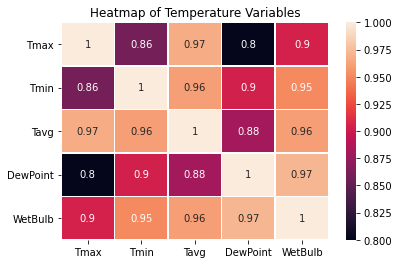

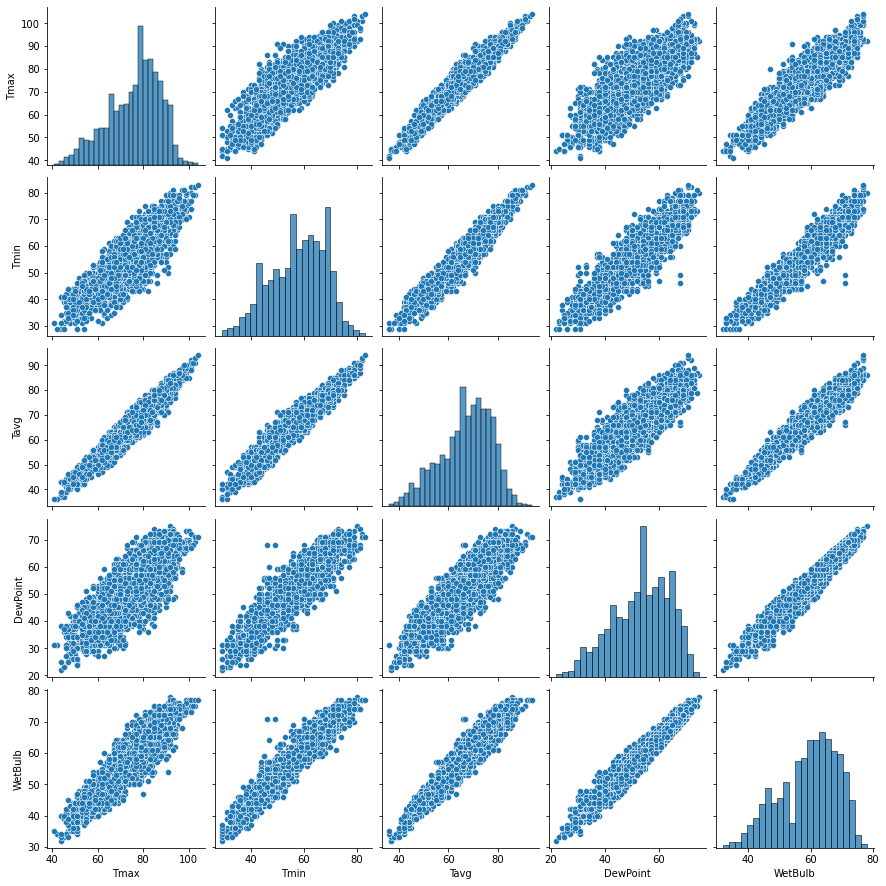

In [44]:
# Plot heatmap to compare temperature variables
ax1 = plt.axes()
sns.heatmap(
    weather[['Tmax','Tmin','Tavg','DewPoint','WetBulb']].corr(),
    annot=True,
    linewidth=0.5,
    vmax=1,
    vmin=0.8,
    ax=ax1
)
ax1.set_title('Heatmap of Temperature Variables')

# Plot pairplot to compare temperature variables
sns.pairplot(weather[['Tmax','Tmin','Tavg','DewPoint','WetBulb']]);


In [45]:
#drop Tmax and Tmin

weather.drop(columns='Tmax',axis=1,inplace=True)
weather.drop(columns='Tmin',axis=1,inplace=True)

**Observations**

Correlation between DewPoint and WetBulb is almost perfect at 0.97.
By definition, both is a measure of humidity, but the difference between the two is:
 * DewPoint is the temperature to which we should cool the air to saturate the air with water vapour
 * WetBulb is the temperature that we can get from a moistened thermometer bulb that is exposed to air flow

Thus we will use DewPoint as a measure of humidity and drop WetBulb

In [46]:
# Drop WetBulb
weather.drop('WetBulb',axis=1, inplace=True)

In [47]:
# Drop Depart
weather.drop('Depart',axis=1, inplace=True)

#### Sunrise/Sunset and Heat/Cool

In [48]:
# Locate rows with sunset & sunrise missing
weather.loc[(weather['Sunset']=='-') | (weather['Sunrise']=='-')]

,Station,Date,Tavg,DewPoint,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,year,month,year_month
1,2,2007-05-01,68,51,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6,2007,5,2007-05
3,2,2007-05-02,52,42,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4,2007,5,2007-05
5,2,2007-05-03,58,40,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2,2007,5,2007-05
7,2,2007-05-04,64,42,7,0,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4,2007,5,2007-05
9,2,2007-05-05,60,39,5,0,-,-,,M,M,M,0.00,29.46,30.09,11.2,7,11.5,2007,5,2007-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2,2014-10-27,67,52,0,2,-,-,RA,M,M,M,0.02,29.00,29.67,12.7,19,13.6,2014,10,2014-10
2937,2,2014-10-28,57,40,8,0,-,-,RA,M,M,M,0.03,29.23,29.85,14.0,26,14.6,2014,10,2014-10
2939,2,2014-10-29,45,34,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.5,29,9.0,2014,10,2014-10
2941,2,2014-10-30,45,35,20,0,-,-,RA,M,M,M,0.00,29.41,30.10,5.9,23,6.5,2014,10,2014-10


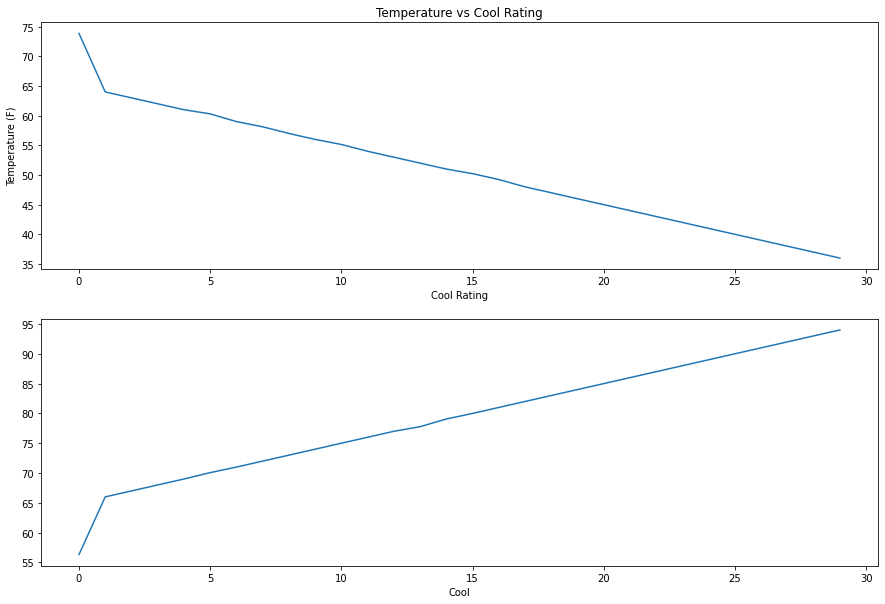

In [49]:
# Create subplot for 2 graphs
fig, axes = plt.subplots(nrows=2, figsize=(15,10))

# Plot 2 graphs to represent temperature vs cool/heat
weather.groupby('Heat')['Tavg'].mean().sort_values().plot(kind='line',ax=axes[0])
axes[0].set_title('Temperature vs Heat Rating',)
axes[0].set_xlabel('Heat Rating')
axes[0].set_ylabel('Temperature (F)')

weather.groupby('Cool')['Tavg'].mean().sort_values().plot(kind='line',ax=axes[1])
axes[0].set_title('Temperature vs Cool Rating',)
axes[0].set_xlabel('Cool Rating')
axes[0].set_ylabel('Temperature (F)');

**Observations**

Based on our grouping, the higher the temperature, the more heat is required, vice-versa

* Heat and Cool  are variables more relevant for calculating energy needs for electrical, natural gas, power, and heating, and air conditioning industries,  not as relevant to risk of mosquito breeding
* Sunrise and Sunset (Timings of sunrise and sunset unlikely affect mosquito breeding)

We will drop these values

In [50]:
weather.drop(columns=['Heat','Cool','Sunset','Sunrise'], axis=1, inplace=True)

### EDA on Code Sum

In [51]:
weather['CodeSum'].unique()

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

**Observations**  

As per the above, there are many dfferent codes representing different conditions. We have decided to classify these conditions based on 4 broad categories and will use these codes to represent weather conditions present:
* Rain = TS / RA / DZ / SH 
* Snow = GR / SN / SG / GS / PL / IC
* Mist = FG / BR / UP 
* Dust = HZ / FU / VA / DU / DS / PO / SA / SS / PY / SQ / DR / BL

In [52]:
# Create features to represent weather
weather['Rain'] = weather.apply(lambda x: 1 if x['CodeSum'] in ('|'.join(['TS', 'RA', 'DZ', 'SH'])) else 0, axis=1)
weather['Snow'] = weather.apply(lambda x: 1 if x['CodeSum'] in ('|'.join(['GR', 'SN', 'SG', 'GS', 'PL','IC'])) else 0, axis=1)
weather['Mist'] = weather.apply(lambda x: 1 if x['CodeSum'] in ('|'.join(['FG','BR','UP'])) else 0, axis=1)
weather['Dust'] = weather.apply(lambda x: 1 if x['CodeSum'] in ('|'.join(['HZ','FU', 'VA', 'DU', 'DS','PO','SA','SS','PY','SQ','DR','BL'])) else 0, axis=1)
weather.head(10)

,Station,Date,Tavg,DewPoint,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,year,month,year_month,Rain,Snow,Mist,Dust
0,1,2007-05-01,67,51,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2007,5,2007-05,0,0,0,0
1,2,2007-05-01,68,51,,M,M,M,0.0,29.18,29.82,2.7,25,9.6,2007,5,2007-05,0,0,0,0
2,1,2007-05-02,51,42,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4,2007,5,2007-05,0,0,1,0
3,2,2007-05-02,52,42,BR HZ,M,M,M,0.0,29.44,30.08,13.3,2,13.4,2007,5,2007-05,0,0,0,0
4,1,2007-05-03,56,40,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9,2007,5,2007-05,0,0,0,0
5,2,2007-05-03,58,40,HZ,M,M,M,0.0,29.46,30.12,12.9,6,13.2,2007,5,2007-05,0,0,0,1
6,1,2007-05-04,58,41,RA,0,M,0.0,0.0,29.31,30.05,10.4,8,10.8,2007,5,2007-05,1,0,0,0
7,2,2007-05-04,64,42,,M,M,M,0.0,29.36,30.04,10.1,7,10.4,2007,5,2007-05,0,0,0,0
8,1,2007-05-05,60,38,,0,M,0.0,0.0,29.40,30.10,11.7,7,12.0,2007,5,2007-05,0,0,0,0
9,2,2007-05-05,60,39,,M,M,M,0.0,29.46,30.09,11.2,7,11.5,2007,5,2007-05,0,0,0,0


In [53]:
# Drop CodeSum
weather.drop(columns='CodeSum',axis=1,inplace=True)

### EDA on Snow/Ice

**Observations**

Both 'Depth' and 'Water1' relate to Snow/Ice conditions. Since the weather data spans the summer months of Chicago, it is not surprising that all the data are zero/missing across these two features. We will drop both features.

In [54]:
print(weather['Depth'].unique())
print(weather['Water1'].unique())

['0' 'M']
['M']


In [55]:
weather.drop(columns=['Depth','Water1'],axis=1, inplace=True)

### EDA on Precipitation

**Observations**

Precipitation features are classified into 'SnowFall' and 'PrecipTotal'. Like the Snow/Ice features, all the 'SnowFall' data are zero/missing. We will drop this feature.

In [56]:
# Snowfall
print(weather['SnowFall'].unique())
print('')
print(weather['SnowFall'].value_counts())

['0.0' 'M' 0 '0.1']

M      1472
0.0    1459
0        12
0.1       1
Name: SnowFall, dtype: int64


In [57]:
# Drop Snowfall
weather.drop(columns='SnowFall',axis=1,inplace=True)

### EDA on Pressure

**Observations**

Correlation between SeaLevel and StnPressure is almost perfect at 0.97.
* This makes sense as stations are based closed to sea level, hence not much pressure differences
* As we intend to use weather information based on proximity of traps to weather station, SeaLevel pressure won't be as accurate

Thus we will use StnPressure as a measure of pressure and drop SeaLevel

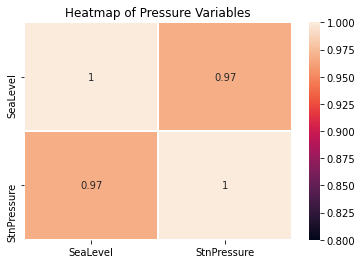

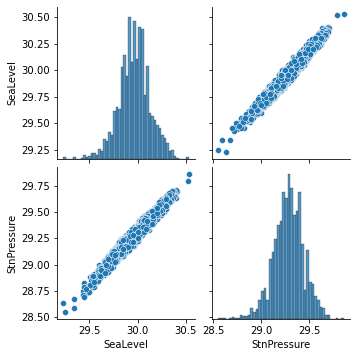

In [58]:
# Plot heatmap to compare pressure variables
ax1 = plt.axes()
sns.heatmap(
    weather[['SeaLevel','StnPressure']].corr(),
    annot=True,
    linewidth=0.5,
    vmax=1,
    vmin=0.8,
    ax=ax1
)
ax1.set_title('Heatmap of Pressure Variables')

# Plot pairplot to compare pressure variables
sns.pairplot(weather[['SeaLevel','StnPressure']]);

In [59]:
# Drop SeaLevel Pressure
weather.drop(columns='SeaLevel',axis=1, inplace=True)

### EDA on Wind

According to [study](https://underc.nd.edu/assets/216551/fullsize/mcreynolds2003.pdf)
 * Among the variables studied, the ones deemed most relevant to mosquito ability to breed and feed were temperature, wind speed, and daily rainfall.
 
**Observations**

There is a strong positive correlation between 'AvgSpeed' and 'ResultSpeed'. We will drop 'ResultSpeed' since 'AvgSpeed' is a more simple representation of wind speed.

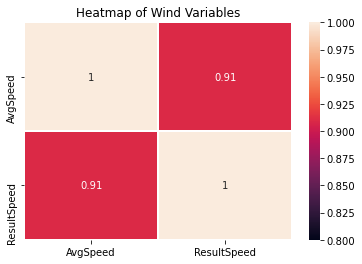

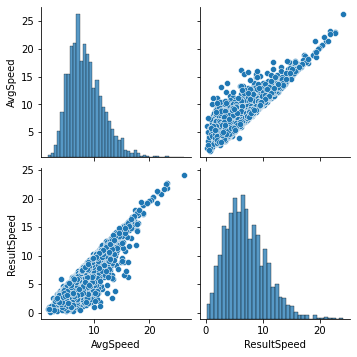

In [60]:
# Plot heatmap to compare wind variables
ax1 = plt.axes()
sns.heatmap(
    weather[['AvgSpeed','ResultSpeed']].corr(),
    annot=True,
    linewidth=0.5,
    vmax=1,
    vmin=0.8,
    ax=ax1
)
ax1.set_title('Heatmap of Wind Variables')

# Plot pairplot to compare wind variables
sns.pairplot(weather[['AvgSpeed','ResultSpeed']]);

Correlation between AvgSpeed and ResultSpeed is highly correlated at 0.91.
 
We will use AvgSpeed as a measure of wind speed and drop ResultSpeed

In [61]:
# Drop ResultSpeed and ResultDir
weather.drop(columns=['ResultSpeed'], axis=1, inplace=True)

### EDA for each variable

**Observation**

To identify whether each feature would be a meaningful predictor of WNV, we evaluated the distribution of the data per feature. Again, there is no variability in the 'Snow' feature (engineered from the 'Code Sum' section) as all of these are zero values. We will drop the 'Snow' feature.

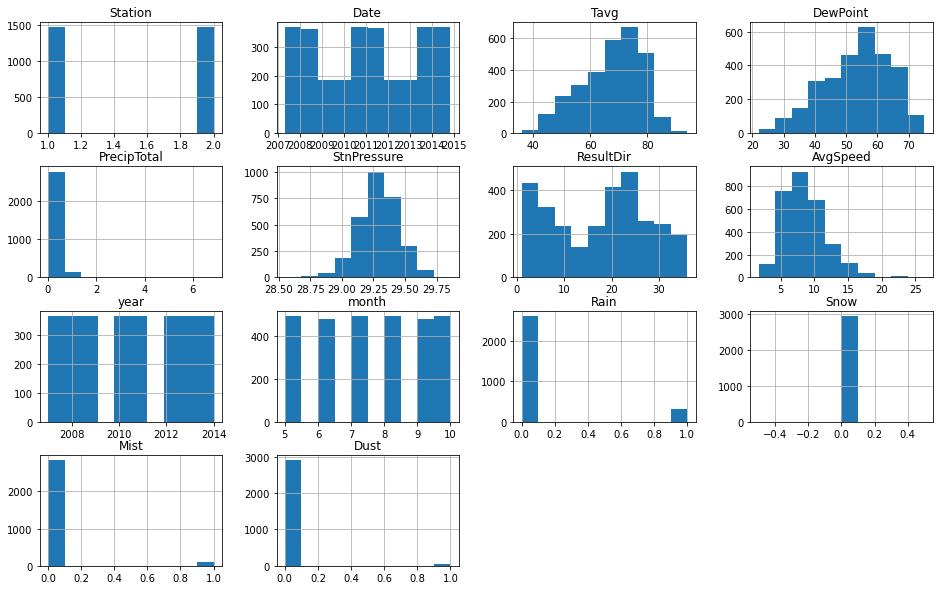

In [62]:
weather.hist(figsize=(16,10));

In [63]:
weather['Snow'].value_counts()

0    2944
Name: Snow, dtype: int64

No variation in Snow feature, hence we'll drop it

In [64]:
weather.drop(columns='Snow',axis=1,inplace=True)

### EDA on Stations

**Observations**

We segmented a few feature EDA by station to see if there are any discernible differences in data between the two stations. 

In general, the weather data appear broadly similar across both stations. 
- Station 1 have a slightly higher number of rainy days and more days with heavier rain ('PrecipTotal' measured in inches). 
- Station 2 have a slightly higher median station pressure since it is located at a lower sea level that Station 1.

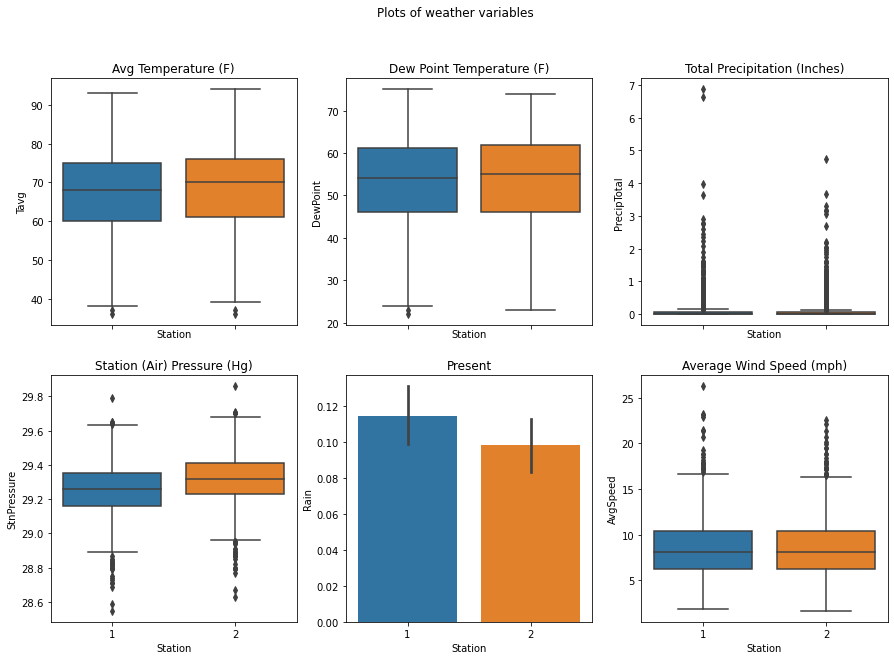

In [65]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
fig.suptitle('Plots of weather variables')

axes[0,0].set_title('Avg Temperature (F)')
sns.boxplot(y="Tavg", x="Station", data=weather, ax=axes[0,0])

axes[0,1].set_title('Dew Point Temperature (F)')
sns.boxplot(y="DewPoint", x="Station", data=weather, ax=axes[0,1])

axes[0,2].set_title('Total Precipitation (Inches)')
sns.boxplot(y="PrecipTotal", x="Station", data=weather, ax=axes[0,2])

axes[1,0].set_title('Station (Air) Pressure (Hg)')
sns.boxplot(y="StnPressure", x="Station", data=weather, ax=axes[1,0])

axes[1,1].set_title('Present')
sns.barplot(y="Rain", x="Station", data=weather, ax=axes[1,1])

axes[1,2].set_title('Average Wind Speed (mph)')
sns.boxplot(y="AvgSpeed", x="Station", data=weather, ax=axes[1,2]);

## Merge Train and Weather datasets

### Assigning stations to train data points

Before we merge the two datasets, we have decided to assign weather data based on the trap's proximity to the nearest weather station. This should provide us with a more accurate representation of the weather condtions for each trap.

In [66]:
def closest_station(latitude, longitude):
    '''Function to deteremine which weather station's data to use based on station proximity to trap'''
                    
    station_1_coord = (41.995, -87.933)
    station_2_coord = (41.786, -87.752)
    entry_coord = (latitude, longitude)
    
    if geodesic(entry_coord, station_1_coord) < geodesic(entry_coord, station_2_coord):
        return 1
    else:
        return 2

In [67]:
train['Station'] = train.apply(lambda x: closest_station(x['Latitude'], x['Longitude']), axis=1)

In [68]:
train.shape

(8475, 13)

### Merge Train and Weather

We have decided to merge the train and weather data sets on the 'Date' and 'Station' fields.

In [69]:
train_weather = train.merge(weather, how="left", on=["Station", "Date"])

In [70]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 8474
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    8475 non-null   datetime64[ns]
 1   Address                 8475 non-null   object        
 2   Species                 8475 non-null   object        
 3   Block                   8475 non-null   int64         
 4   Street                  8475 non-null   object        
 5   Trap                    8475 non-null   object        
 6   AddressNumberAndStreet  8475 non-null   object        
 7   Latitude                8475 non-null   float64       
 8   Longitude               8475 non-null   float64       
 9   AddressAccuracy         8475 non-null   int64         
 10  NumMosquitos            8475 non-null   int64         
 11  WnvPresent              8475 non-null   int64         
 12  Station                 8475 non-null   int64   

## EDA on Overall Data

### WNV Occurence

**Observations**

WNV preaks in Augst each year, with a sharp increase starting from July. Likelihood of WNV from mosquitoes caught in the traps was the highest in Aug 2007.

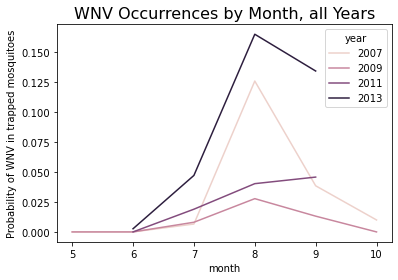

In [71]:
plt.plot(figsize=(15,5))

wnv_time = train_weather[['month','year','WnvPresent']]
sns.lineplot(x = wnv_time['month'], y = 'WnvPresent', data = wnv_time, hue = 'year', ci = None, legend = 'full')
plt.ylabel('Probability of WNV in trapped mosquitoes')
plt.title('WNV Occurrences by Month, all Years', fontsize=16);

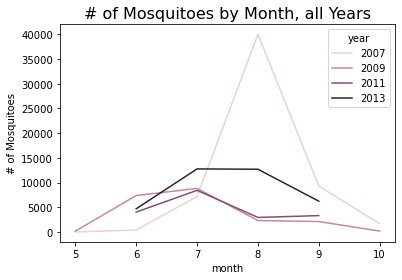

In [72]:
plt.plot(figsize=(15,5))

mosquitos_time = pd.DataFrame(train_weather.groupby(['year','month'])['NumMosquitos'].sum()).reset_index()
sns.lineplot(x = mosquitos_time['month'], y = 'NumMosquitos', data = mosquitos_time, hue = 'year', ci = None, legend = 'full')
plt.ylabel('# of Mosquitoes')
plt.title('# of Mosquitoes by Month, all Years', fontsize=16);

### Species Analysis

Of the 5 species that were recorded in this dataset, only 3 main species were known to cause WNV. These are:
- Culex Pipiens/Restuans
- Culex Restuans
- Culex Pipiens

We will therefore drop the rest of the species from the datasets since they will not be able to predict whether it cause WNV or not.

Text(0.5, 1.0, '# Samples per Species')

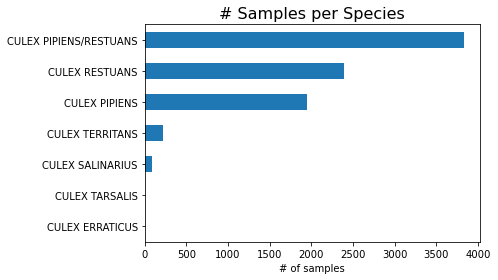

In [73]:
plt.plot(figsize=(15,5))

train_weather['Species'].value_counts().sort_values().plot(kind='barh')
plt.xlabel('# of samples')
plt.title('# Samples per Species', fontsize=16)

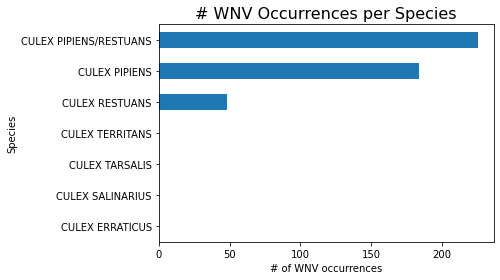

In [74]:
plt.plot(figsize=(15,5))

wnv_species = train_weather.groupby('Species')['WnvPresent'].sum().sort_values(ascending=False)
wnv_species.sort_values().plot(kind='barh')
plt.xlabel('# of WNV occurrences')
plt.title('# WNV Occurrences per Species', fontsize=16);

In [75]:
train_weather['WnvPresent'].sum()

457

In [76]:
#Keep only mosquitoes species that predict WNV

train_weather = train_weather.loc[(train_weather['Species']=='CULEX PIPIENS/RESTUANS')|
                 (train_weather['Species']=='CULEX PIPIENS')|
                 (train_weather['Species']=='CULEX RESTUANS'), :].reset_index(drop=True)



In [77]:
#Dummify species

train_weather['Pipiens'] = train_weather.apply(lambda row: 1 if 'PIPIENS' in row['Species'] else 0, axis=1)
train_weather['Restuans'] = train_weather.apply(lambda row: 1 if 'RESTUANS' in row['Species'] else 0, axis=1)


In [78]:
train_weather.drop("Species", axis=1, inplace=True)

In [79]:
train_weather

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tavg,DewPoint,PrecipTotal,StnPressure,ResultDir,AvgSpeed,year,month,year_month,Rain,Mist,Dust,Pipiens,Restuans
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,2,77,59,0.00,29.44,16,7.4,2007,5,2007-05,0,0,0,1,1
1,2011-07-29,"7000 West Armitage Avenue, Chicago, IL 60707, USA",70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,147,0,1,79,67,0.70,29.28,4,5.9,2011,7,2011-07,0,1,0,1,1
2,2011-07-29,"7000 West Armitage Avenue, Chicago, IL 60707, USA",70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,1,0,1,79,67,0.70,29.28,4,5.9,2011,7,2011-07,0,1,0,1,0
3,2011-07-29,"7000 North Moselle Avenue, Chicago, IL 60646, USA",70,N MOSELL AVE,T008,"7000 N MOSELL AVE, Chicago, IL",42.008314,-87.777921,9,2,0,1,79,67,0.70,29.28,4,5.9,2011,7,2011-07,0,1,0,0,1
4,2011-07-29,"7000 North Moselle Avenue, Chicago, IL 60646, USA",70,N MOSELL AVE,T008,"7000 N MOSELL AVE, Chicago, IL",42.008314,-87.777921,9,3,0,1,79,67,0.70,29.28,4,5.9,2011,7,2011-07,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,2007-08-22,"South Stony Island Avenue, Chicago, IL, USA",10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,1054,1,2,80,70,0.88,29.29,21,8.4,2007,8,2007-08,0,0,0,1,0
8165,2007-08-22,"South Doty Avenue, Chicago, IL, USA",12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,1554,1,2,80,70,0.88,29.29,21,8.4,2007,8,2007-08,0,0,0,1,0
8166,2013-08-29,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,281,1,1,78,64,0.00,29.29,10,4.7,2013,8,2013-08,0,0,0,1,0
8167,2013-08-01,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,984,1,1,71,57,0.00,29.23,30,7.8,2013,8,2013-08,0,0,0,1,1


### Correlation between WNV and features

**Observations**

From the heatmap below, there is little correlation between features and 'WnvPresent'. There is a positive correlation between average temperature and dewpoint.

In [80]:
#Dataframe with only features that we want to analyse against WnvPresent

weather_features = train_weather.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet','Latitude','Longitude','AddressAccuracy','NumMosquitos','year','month','Station'], axis=1)

In [81]:
wnv_weather_corr = weather_features.corr()[['WnvPresent']].sort_values(by='WnvPresent', ascending=False)

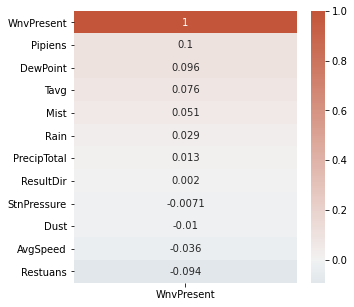

In [82]:
plt.figure(figsize =(5,5))

sns.heatmap(wnv_weather_corr, annot=True, cmap=sns.diverging_palette(230, 20, sep=1, as_cmap=True), center=0);

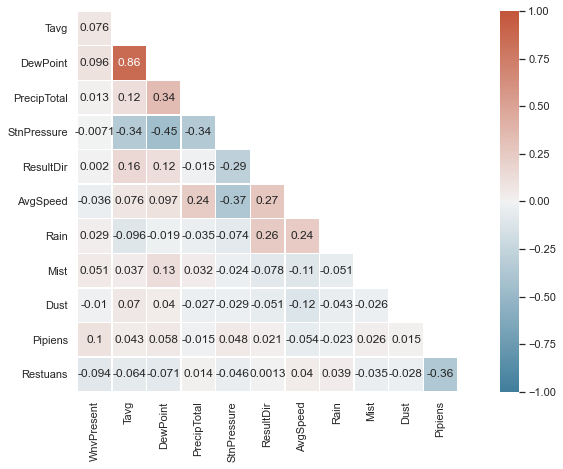

In [83]:
plt.figure(figsize=(15,7))

weather_features_corr = weather_features.corr()

sns.set_theme(style="white")
mask = np.triu(np.ones_like(weather_features_corr, dtype=bool))
mask = mask[1: ,:-1]
weather_features_corr = weather_features_corr.iloc[1:,:-1].copy()
cmap = sns.diverging_palette(230, 20, sep=1, as_cmap=True)
                             
sns.heatmap(weather_features_corr, annot=True, mask=mask, cmap=cmap, square=True, linewidth=0.5, vmax=1, vmin=-1);

Dropping 'ResultDir' since the correlation is low

In [84]:
train_weather.drop(columns=['ResultDir'], axis=1, inplace=True)

### Trends Between WNV and Weather Features

**Observations**

- In general, high precipitation and temperature are linked to higher likelihood of WNV in the traps.

- Potential lags between weather feature and impact on WNV Occurrences.
    - For example, average temperatures reached its peak in July for 2011 and 2013, but we only see WnvPresent likelihood reach its highest in August of those years.

In [85]:
def plot_wnv_weather(feature):

    fig, ax = plt.subplots(figsize=(20,8))
    ax.plot(weather_features.groupby('year_month')[feature].mean(),color="skyblue", marker="x")
    ax.set_xlabel("year_month",fontsize=16)
    ax.set_ylabel(feature,color="skyblue",fontsize=16)

    ax2=ax.twinx()
    ax2.plot(weather_features.groupby('year_month')['WnvPresent'].mean(),color="darkblue",marker="o")
    ax2.set_ylabel("WnvPresent",color="darkblue",fontsize=16)
    
    plt.title(f'Occurrences of WNV vs {feature}', fontsize=18)
    plt.tight_layout
    plt.show()

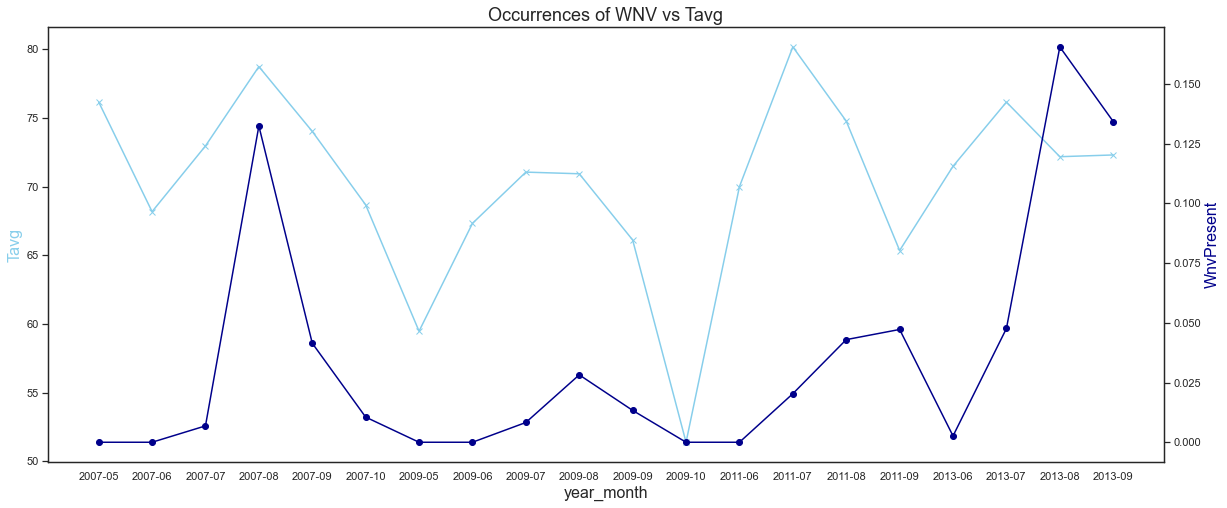

In [86]:
plot_wnv_weather('Tavg')

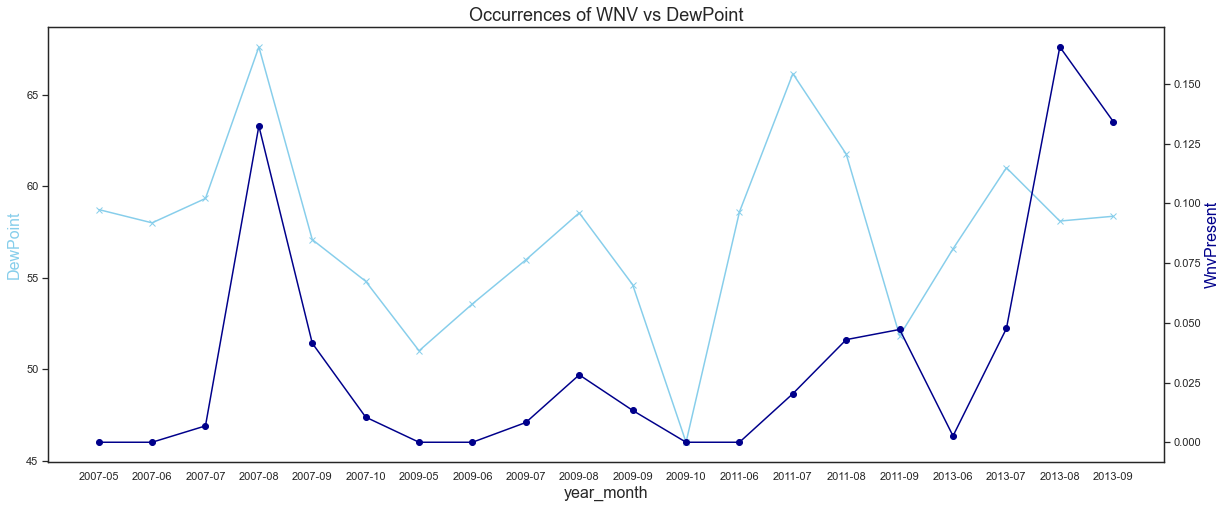

In [87]:
plot_wnv_weather('DewPoint')

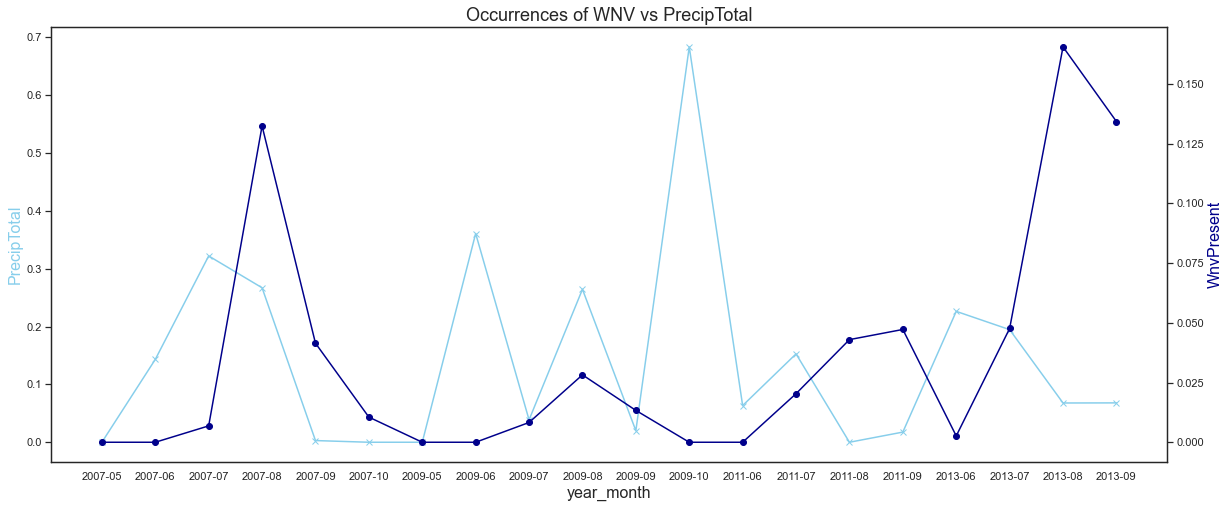

In [88]:
plot_wnv_weather('PrecipTotal')

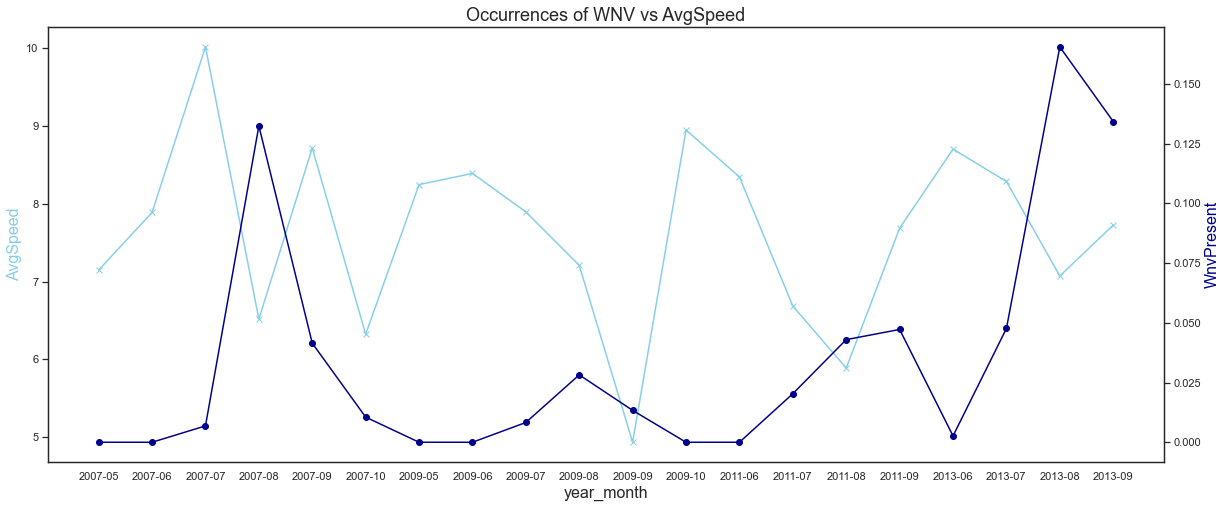

In [89]:
plot_wnv_weather('AvgSpeed')

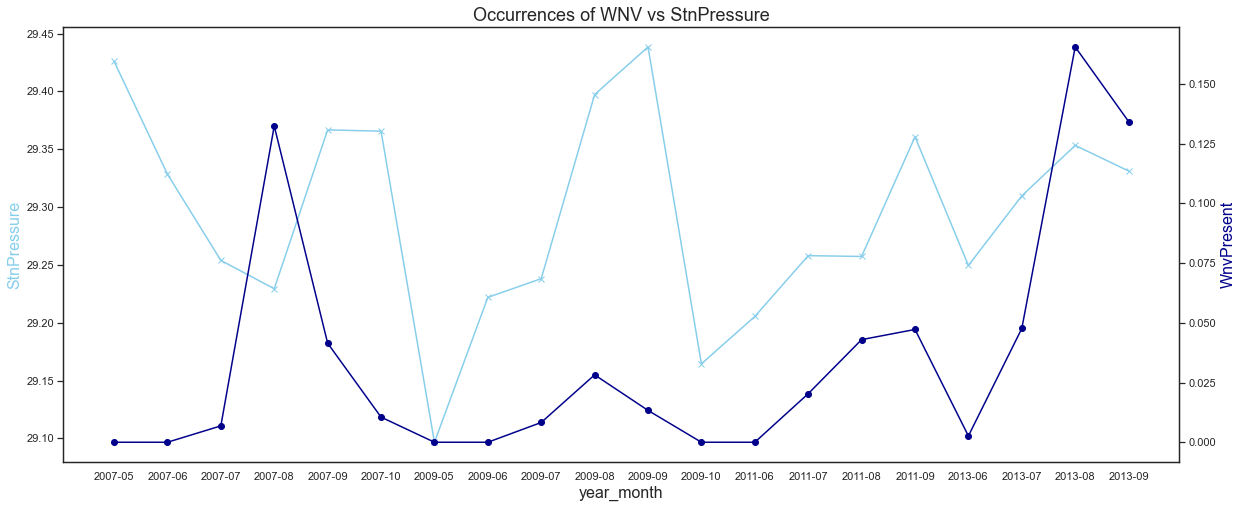

In [90]:
plot_wnv_weather('StnPressure')

## Feature Engineering

### Polynomial Features/Interaction Terms

Like the individual weather features, the interaction terms created also have low correlation with 'WnvPresent'. As such, we have decided to select only a few terms to keep for our modelling:



In [91]:
weather_features

,WnvPresent,Tavg,DewPoint,PrecipTotal,StnPressure,ResultDir,AvgSpeed,year_month,Rain,Mist,Dust,Pipiens,Restuans
0,0,77,59,0.00,29.44,16,7.4,2007-05,0,0,0,1,1
1,0,79,67,0.70,29.28,4,5.9,2011-07,0,1,0,1,1
2,0,79,67,0.70,29.28,4,5.9,2011-07,0,1,0,1,0
3,0,79,67,0.70,29.28,4,5.9,2011-07,0,1,0,0,1
4,0,79,67,0.70,29.28,4,5.9,2011-07,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,1,80,70,0.88,29.29,21,8.4,2007-08,0,0,0,1,0
8165,1,80,70,0.88,29.29,21,8.4,2007-08,0,0,0,1,0
8166,1,78,64,0.00,29.29,10,4.7,2013-08,0,0,0,1,0
8167,1,71,57,0.00,29.23,30,7.8,2013-08,0,0,0,1,1


In [92]:
features = list(weather_features.drop(columns=['WnvPresent','year_month']).columns)
features = list(map(str, features))
X = weather_features.drop(columns=['WnvPresent','year_month'])

In [93]:
poly = PolynomialFeatures(include_bias=False, degree=2)
X_poly = poly.fit_transform(X)

In [94]:
poly_features = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))
poly_corr = poly_features.corrwith(weather_features['WnvPresent']).sort_values(ascending=False)
poly_corr.head(10)

DewPoint Pipiens        0.120783
Tavg Pipiens            0.112732
Pipiens^2               0.100507
Pipiens                 0.100507
StnPressure Pipiens     0.100368
DewPoint StnPressure    0.097238
DewPoint^2              0.097070
DewPoint                0.096221
Tavg DewPoint           0.090581
Tavg StnPressure        0.076994
dtype: float64

In [95]:
#Add selected polynominal features/interaction terms to train_weather set

# poly_features_add = poly_features[['Tavg DewPoint', 'DewPoint StnPressure', 'Tavg StnPressure']]
# train_weather = train_weather.join(poly_features_add)

In [96]:
train_weather 

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,year,month,year_month,Rain,Mist,Dust,Pipiens,Restuans
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,2,77,59,0.00,29.44,7.4,2007,5,2007-05,0,0,0,1,1
1,2011-07-29,"7000 West Armitage Avenue, Chicago, IL 60707, USA",70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,147,0,1,79,67,0.70,29.28,5.9,2011,7,2011-07,0,1,0,1,1
2,2011-07-29,"7000 West Armitage Avenue, Chicago, IL 60707, USA",70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,1,0,1,79,67,0.70,29.28,5.9,2011,7,2011-07,0,1,0,1,0
3,2011-07-29,"7000 North Moselle Avenue, Chicago, IL 60646, USA",70,N MOSELL AVE,T008,"7000 N MOSELL AVE, Chicago, IL",42.008314,-87.777921,9,2,0,1,79,67,0.70,29.28,5.9,2011,7,2011-07,0,1,0,0,1
4,2011-07-29,"7000 North Moselle Avenue, Chicago, IL 60646, USA",70,N MOSELL AVE,T008,"7000 N MOSELL AVE, Chicago, IL",42.008314,-87.777921,9,3,0,1,79,67,0.70,29.28,5.9,2011,7,2011-07,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,2007-08-22,"South Stony Island Avenue, Chicago, IL, USA",10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,1054,1,2,80,70,0.88,29.29,8.4,2007,8,2007-08,0,0,0,1,0
8165,2007-08-22,"South Doty Avenue, Chicago, IL, USA",12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,1554,1,2,80,70,0.88,29.29,8.4,2007,8,2007-08,0,0,0,1,0
8166,2013-08-29,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,281,1,1,78,64,0.00,29.29,4.7,2013,8,2013-08,0,0,0,1,0
8167,2013-08-01,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,984,1,1,71,57,0.00,29.23,7.8,2013,8,2013-08,0,0,0,1,1


## Feature Engineering: Neighbourhood Classification based on WNV Occurrences

We have also classify addresses based on the total occurences of WNV. These are the categories:

- Very Low Risk: 0 and 1 cases
- Low Risk: 2 and 3 cases
- Medium Risk: 4 and 5 cases
- High Risk: 6 and 7 cases
- Very High Risk: 8 cases and above

In [97]:
address_wnv = pd.DataFrame(train_weather.groupby('Address')['WnvPresent'].sum()).reset_index()

In [98]:
address_wnv.describe()

,WnvPresent
count,138.000000
mean,3.311594
std,4.025105
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,29.000000


In [99]:
address_wnv['risk_rating'] = pd.cut(address_wnv['WnvPresent'], bins=[0, 2, 4, 6, 8, 67], right=False, labels=['very_low_risk','low_risk','medium_risk','high_risk','very_high_risk'], ordered=True)
address_wnv.drop(columns='WnvPresent', inplace=True)

In [100]:
train_weather = train_weather.merge(address_wnv, how='left', on='Address')

In [101]:
risk_rating_df = pd.get_dummies(train_weather['risk_rating'])

,very_low_risk,low_risk,medium_risk,high_risk,very_high_risk
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
8164,0,0,0,0,1
8165,0,0,0,0,1
8166,0,0,0,0,1
8167,0,0,0,0,1


In [102]:
train_weather = pd.concat([train_weather, risk_rating_df], axis=1)
train_weather

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,year,month,year_month,Rain,Mist,Dust,Pipiens,Restuans,risk_rating,very_low_risk,low_risk,medium_risk,high_risk,very_high_risk
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,2,77,59,0.00,29.44,7.4,2007,5,2007-05,0,0,0,1,1,medium_risk,0,0,1,0,0
1,2011-07-29,"7000 West Armitage Avenue, Chicago, IL 60707, USA",70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,147,0,1,79,67,0.70,29.28,5.9,2011,7,2011-07,0,1,0,1,1,high_risk,0,0,0,1,0
2,2011-07-29,"7000 West Armitage Avenue, Chicago, IL 60707, USA",70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,1,0,1,79,67,0.70,29.28,5.9,2011,7,2011-07,0,1,0,1,0,high_risk,0,0,0,1,0
3,2011-07-29,"7000 North Moselle Avenue, Chicago, IL 60646, USA",70,N MOSELL AVE,T008,"7000 N MOSELL AVE, Chicago, IL",42.008314,-87.777921,9,2,0,1,79,67,0.70,29.28,5.9,2011,7,2011-07,0,1,0,0,1,very_high_risk,0,0,0,0,1
4,2011-07-29,"7000 North Moselle Avenue, Chicago, IL 60646, USA",70,N MOSELL AVE,T008,"7000 N MOSELL AVE, Chicago, IL",42.008314,-87.777921,9,3,0,1,79,67,0.70,29.28,5.9,2011,7,2011-07,0,1,0,1,1,very_high_risk,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,2007-08-22,"South Stony Island Avenue, Chicago, IL, USA",10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,1054,1,2,80,70,0.88,29.29,8.4,2007,8,2007-08,0,0,0,1,0,very_high_risk,0,0,0,0,1
8165,2007-08-22,"South Doty Avenue, Chicago, IL, USA",12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,1554,1,2,80,70,0.88,29.29,8.4,2007,8,2007-08,0,0,0,1,0,very_high_risk,0,0,0,0,1
8166,2013-08-29,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,281,1,1,78,64,0.00,29.29,4.7,2013,8,2013-08,0,0,0,1,0,very_high_risk,0,0,0,0,1
8167,2013-08-01,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,984,1,1,71,57,0.00,29.23,7.8,2013,8,2013-08,0,0,0,1,1,very_high_risk,0,0,0,0,1


## Update Test Set

In [ ]:
# #merge test and weather
# test_weather = test.merge(weather, how="left", on=["Station", "Date"])


# #Covert Date
# weather['Date'] = pd.to_datetime(weather['Date'])

# #New date columns
# weather['year'] = pd.to_datetime(weather['Date']).dt.year
# weather['month'] = pd.to_datetime(weather['Date']).dt.month
# weather['year_month'] = pd.to_datetime(weather['Date']).dt.to_period('M').astype(str)

# #Check for mosquito species


# #Dummify species

# train_weather['Pipiens'] = train_weather.apply(lambda row: 1 if 'PIPIENS' in row['Species'] else 0, axis=1)
# train_weather['Restuans'] = train_weather.apply(lambda row: 1 if 'RESTUANS' in row['Species'] else 0, axis=1)
# train_weather.drop("Species", axis=1, inplace=True)


# #Weather columns to drop
# train_weather.drop(columns=['ResultDir'], axis=1, inplace=True)

# #poly features

# #risk rating
# address_wnv = pd.DataFrame(train_weather.groupby('Address')['WnvPresent'].sum()).reset_index()
# address_wnv['risk_rating'] = pd.cut(address_wnv['WnvPresent'], bins=[0, 2, 4, 6, 8, 67], right=False, labels=['very_low_risk','low_risk','medium_risk','high_risk','very_high_risk'], ordered=True)
# address_wnv.drop(columns='WnvPresent', inplace=True)

# train_weather = train_weather.merge(address_wnv, how='left', on='Address')
# risk_rating_df = pd.get_dummies(train_weather['risk_rating'])
# train_weather = pd.concat([train_weather, risk_rating_df], axis=1)

In [104]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8169 entries, 0 to 8168
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    8169 non-null   datetime64[ns]
 1   Address                 8169 non-null   object        
 2   Block                   8169 non-null   int64         
 3   Street                  8169 non-null   object        
 4   Trap                    8169 non-null   object        
 5   AddressNumberAndStreet  8169 non-null   object        
 6   Latitude                8169 non-null   float64       
 7   Longitude               8169 non-null   float64       
 8   AddressAccuracy         8169 non-null   int64         
 9   NumMosquitos            8169 non-null   int64         
 10  WnvPresent              8169 non-null   int64         
 11  Station                 8169 non-null   int64         
 12  Tavg                    8169 non-null   int64   

## Export Dataset

In [103]:
train_weather.shape

(8169, 31)

In [ ]:
#train_weather.to_csv(r'../datasets/train_weather.csv', index=False)

In [ ]:
#test_weather.to_csv(r'../datasets/train_weather.csv', index=False)

TBC feature engineering
- classify neighbourhoods based on virus cases
- dummify species?